In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from transformer import *
import os
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Pickle

In [26]:
import pickle

try:
    table = pd.read_pickle('../association_table.pkl')
except:
    table = pd.read_excel('../Cas_D_Etude/Cas_Etude_Volcano/NE PAS OUVRIR/association_table.xlsx')
    table.to_pickle("../Cas_D_Etude/Cas_Etude_Vulcano/association_table.pkl")

# Sampling data

In [27]:
from transformer import Event
from subsampler import balanced_subsampler

table = Event().fit_transform(table)
balanced_table = balanced_subsampler(table, 100)
balanced_table.event.value_counts()

TOR    100
TR     100
PIS    100
HIB    100
VT     100
EXP    100
LP     100
Name: event, dtype: int64

In [33]:
balanced_table.to_pickle("/home/d5learner-08/GDrive/Cas_D_Etude/Cas_Etude_Vulcano/association_balanced_table.pkl")

In [75]:
balanced_table.head(5)

,Index,Event,Duration,Event start,Event stop,File name,File start,File end,Sampling rate,Overlap,Unnamed: 10,Unnamed: 11,Unnamed: 12,npts,energy,path,event
68058,68058,TR2,354,2007-04-23 03:16:13.990000+00:00,2007-04-23 03:22:07.990000+00:00,20070423_0300.UB1.SL.Z.sac,2007-04-23 03:00:00.019000+00:00,2007-04-23 03:59:59.969000+00:00,40.0,False,NaN,NaN,NaN,143999.0,0.72632,C:/Users/EC265595/Documents/Data/Ubinas_2006_2...,TR
100084,100084,PIS,27,2008-02-17 06:17:15.150000+00:00,2008-02-17 06:17:42.150000+00:00,20080217_0600.UB1.SL.Z.sac,2008-02-17 06:00:00.036000+00:00,2008-02-17 07:00:00.036000+00:00,50.0,False,NaN,NaN,NaN,180001.0,0.39290,C:/Users/EC265595/Documents/Data/Ubinas_2006_2...,PIS
80771,80771,TR1,2701,2007-06-16 11:00:10.670000+00:00,2007-06-16 11:45:11.670000+00:00,20070616_1100.UB1.SL.Z.sac,2007-06-16 10:59:59.993000+00:00,2007-06-16 11:59:59.993000+00:00,100.0,False,NaN,NaN,NaN,360001.0,11.18200,C:/Users/EC265595/Documents/Data/Ubinas_2006_2...,TR
121808,121808,TOR,27,2011-01-22 05:40:34.710000+00:00,2011-01-22 05:41:01.710000+00:00,20110122_0500.UB1.SL.Z.sac,2011-01-22 05:00:00.043000+00:00,2011-01-22 06:00:00.043000+00:00,100.0,False,NaN,NaN,NaN,360001.0,0.02427,C:/Users/EC265595/Documents/Data/Ubinas_2006_2...,TOR
115494,115494,VT1,27,2009-12-02 02:50:06.150000+00:00,2009-12-02 02:50:33.150000+00:00,20091202_0200.UB1.SL.Z.sac,2009-12-02 02:00:00.036000+00:00,2009-12-02 03:00:00.036000+00:00,50.0,False,NaN,NaN,NaN,180001.0,69.37142,C:/Users/EC265595/Documents/Data/Ubinas_2006_2...,VT


# Pré-processing Data and créate Features

In [83]:
path = "data/Extracted/"
transfo = Transformer(path)
table_transf=transfo.fit_transform(balanced_table)

In [84]:
table_transf.to_pickle("/home/d5learner-08/GDrive/Cas_D_Etude/Cas_Etude_Vulcano/association_table_transfo.pkl")

In [85]:
table_transf.head(5)

,Index,Event,Duration,Event start,Event stop,Sampling rate,Overlap,npts,energy,path,...,amplitude,kurtosis,skew,variance_TF,mean_TF,median_TF,maximum_TF,amplitude_TF,kurtosis_TF,skew_TF
68058,68058,TR2,354,2007-04-23 03:16:13.990000+00:00,2007-04-23 03:22:07.990000+00:00,40.0,False,143999.0,0.72632,data/Extracted/TR/TR_68058.npy,...,2543.000000,2.390456,-0.119990,24.773052,1.981910,0.552380,456.369350,456.365152,4905.109534,54.545308
100084,100084,PIS,27,2008-02-17 06:17:15.150000+00:00,2008-02-17 06:17:42.150000+00:00,50.0,False,180001.0,0.39290,data/Extracted/PIS/PIS_100084.npy,...,976.000000,1.501916,-0.052582,36.803631,3.775980,1.660664,107.445926,107.443388,69.543058,5.704484
80771,80771,TR1,2701,2007-06-16 11:00:10.670000+00:00,2007-06-16 11:45:11.670000+00:00,100.0,False,360001.0,11.18200,data/Extracted/TR/TR_80771.npy,...,3429.000000,1.878277,-0.025397,0.555120,0.323081,0.133632,135.117475,135.117371,4000.806366,26.604645
121808,121808,TOR,27,2011-01-22 05:40:34.710000+00:00,2011-01-22 05:41:01.710000+00:00,100.0,False,360001.0,0.02427,data/Extracted/TOR/TOR_121808.npy,...,486.641968,5.103905,0.190435,2.253464,0.611769,0.005847,14.819391,14.818016,23.808191,4.330444
115494,115494,VT1,27,2009-12-02 02:50:06.150000+00:00,2009-12-02 02:50:33.150000+00:00,50.0,False,180001.0,69.37142,data/Extracted/VT/VT_115494.npy,...,32.000000,0.309994,-0.130074,10.383140,0.215640,0.077717,118.200000,118.198706,1328.395931,36.364759


# Test des features avec Random Forest

In [86]:
# gridsearch for the Random Forest classifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

liste_X =["Duration","energy", "mean", "median", "maximum",  "amplitude", "variance", "kurtosis" ,"skew",
         'variance_TF' ,'mean_TF' ,'median_TF' ,'maximum_TF','amplitude_TF','kurtosis_TF','skew_TF']

y=table_transf.event.copy()
X=table_transf[liste_X]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 10)

k_range = [60,80,100,150]
param_grid =  {'n_estimators': k_range}

RF_clf=RandomForestClassifier()

grid_search = GridSearchCV(RF_clf, param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

print(grid_search.best_score_)
print(grid_search.best_params_)

RF_clf.fit(X_train, y_train)


0.6857142857142856
{'n_estimators': 60}


RandomForestClassifier()

In [87]:
# scorre 
RF_clf.score(X_test,y_test)

0.6457142857142857

In [98]:
# Random forest - feature_importances
liste_feature_importances=[a for a in zip(RF_clf.feature_importances_,liste_X)]
liste_feature_importances.sort(key = lambda x: x[0],reverse=True)
liste_feature_importances

[(0.16388971478249703, 'energy'),
 (0.14541045878575237, 'Duration'),
 (0.07265331069813939, 'mean_TF'),
 (0.07005933434043325, 'variance_TF'),
 (0.0650424718199598, 'median_TF'),
 (0.05567995720803169, 'variance'),
 (0.050734616692955224, 'mean'),
 (0.04994764242728854, 'kurtosis_TF'),
 (0.04713141287868927, 'maximum_TF'),
 (0.04493241493429685, 'amplitude_TF'),
 (0.04413523269041178, 'amplitude'),
 (0.04325327140414188, 'median'),
 (0.04258347814758629, 'maximum'),
 (0.03641986735369376, 'kurtosis'),
 (0.03624274934667814, 'skew_TF'),
 (0.031884066489444814, 'skew')]

In [101]:
liste_features_selected=['energy', 'Duration', 'mean_TF', 'variance_TF', 'median_TF','variance', 'mean','kurtosis_TF']

In [104]:
# gridsearch for the Random Forest classifier

y=table_transf.event.copy()
X=table_transf[liste_features_selected]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 10)

k_range = [30,50,100,150]
d_range=[5,10,15]
param_grid =  {'n_estimators': k_range, 'max_depth': d_range}

RF_clf=RandomForestClassifier()

grid_search = GridSearchCV(RF_clf, param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

print(grid_search.best_score_)
print(grid_search.best_params_)

RF_clf.fit(X_train, y_train)


0.6857142857142856
{'max_depth': 15, 'n_estimators': 50}


RandomForestClassifier()

In [105]:
liste_feature_importances=[a for a in zip(RF_clf.feature_importances_,liste_features_selected)]
liste_feature_importances.sort(key = lambda x: x[0],reverse=True)
liste_feature_importances

[(0.21479120999968493, 'energy'),
 (0.16474379264157082, 'Duration'),
 (0.11732446442694928, 'variance_TF'),
 (0.10774811188938604, 'median_TF'),
 (0.10713113198443003, 'variance'),
 (0.10249596613616661, 'mean_TF'),
 (0.09801465593267356, 'mean'),
 (0.08775066698913882, 'kurtosis_TF')]

# kurtosis, skew

import numpy as np
from scipy.stats import kurtosis
from scipy.stats import skew
from transformer import Transformer

path = "data/Extracted/"

transfo = Transformer(path)
y=transfo.open_file(balanced_table,74458)


print( 'excess kurtosis of normal distribution (should be 0): {}'.format( kurtosis(y) ))
print( 'skewness of normal distribution (should be 0): {}'.format( skew(y) ))


%store df

%store -r df

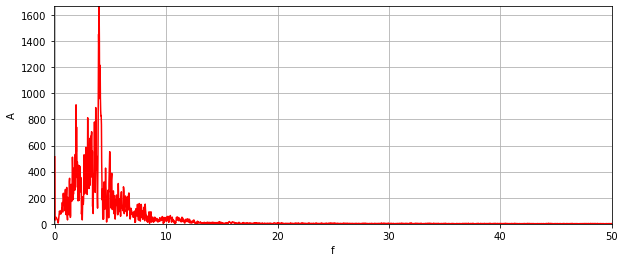

In [70]:
import math
import numpy as np
from matplotlib.pyplot import *
from numpy.fft import fft 
from scipy import fftpack

T = table_transf.loc[74458,'Duration'] # Durée échantillonnage
fe = table_transf.loc[74458,'Sampling rate']  # Freq échantionnage
echantillons = np.load(table_transf.loc[74458,'path'])

tfd = fft(echantillons)
N=len(echantillons)
spectre = np.absolute(tfd)*2/N
            

#L'échelle des fréquences est construite sachant que l'espacement fréquentiel de deux points de la TFD est l'inverse de la durée T :
freq=np.arange(N)*1.0/T
           
#On trace le spectre pour des fréquences allant de zéro à la moitié de la fréquence d'échantillonnage :

figure(figsize=(10,4))
plot(freq,spectre,'r')
xlabel('f')
ylabel('A')
axis([-0.1,fe/2,0,spectre.max()])
grid()


X = fftpack.fft(echantillons)   

